### Import and loading

####  Modules import

In [1]:
import importlib
from pathlib import Path,PureWindowsPath,PurePosixPath
import re

import pandas as pd

from src import preprocessing
from src import plot_token
from src import html_parser
from src import nlp
from src import io_file

#_ = list(map(importlib.reload,[plot_token]))

#### Load file

In [2]:
data = io_file.load_input()

### Data description

#### Simple stats

In [3]:
print(f"Nb questions: {len(data)}.")
data[["Score","ViewCount","FavoriteCount","AnswerCount"]].describe()

Nb questions: 27338.


Score     ViewCount  FavoriteCount   AnswerCount
count  27338.000000  2.733800e+04   27338.000000  27338.000000
mean     113.008523  1.090891e+05      42.724888      7.117236
std      346.850157  2.413333e+05     146.186050      6.735040
min        6.000000  2.610000e+02      11.000000      1.000000
25%       29.000000  2.126625e+04      14.000000      3.000000
50%       51.000000  4.780600e+04      19.000000      5.000000
75%       98.000000  1.094415e+05      35.000000      9.000000
max    26377.000000  9.893978e+06   11586.000000    126.000000

#### Data head

In [4]:
data.head()

Title  \
0  SQL Server 2008 Full Text Search (FTS) versus ...   
1              XML Serialization and Inherited Types   
2                               MyISAM versus InnoDB   
3  Recommended SQL database design for tags or ta...   
4          Specifying a mySQL ENUM in a Django model   

                                                Body  \
0  <p>I know there have been questions in the pas...   
1  <p>Following on from my <a href="https://stack...   
2  <p>I'm working on a projects which involves a ...   
3  <p>I've heard of a few ways to implement taggi...   
4  <p>How do I go about specifying and using an E...   

                                                Tags      Id  Score  \
0  <sql-server><sql-server-2008><full-text-search...  499247     40   
1  <c#><xml><inheritance><serialization><xml-seri...   20084     86   
2     <mysql><database><performance><innodb><myisam>   20148    887   
3  <sql><database-design><tags><data-modeling><ta...   20856    325   
4      <python><mysql><django><django-models><enums>   21454     99   

   ViewCount  FavoriteCount  AnswerCount  
0      18582             26            5  
1      56816             42            7  
2     301985            390           25  
3     118552            307            6  
4      61572             21            9

The input dataset is a selection of questions from site https://stackoverflow.com/. This dataset contains:
- Title (of the question)
- Body (html encoded) of the question
- Tags associated with the questions
plus some statistics about questions.

There are 27 333 questions.

### Data Processing

The three columns cited above (Title-Body-Tags) are used to create new columns: 

-ntags: list of normalized tags
-title-tokens: list of  tokens present in Title

-content: dictionary with keys as html tags and values as content present in Body
-body-tokens:  tokens of body created from content
-body-tokens-wov:  tokens of body created from content WithOut verbs



#### Common settings

In [5]:
common_signs   = [
    '\\(','\\)','\\[','\\]','\\{','\\}','\\?','\\.',';',',',':','\\|','\\=','\\-','\\+','"',"'",'&','%','\\*','\\','/','\\!','#',
    '_','<','>','@','§','~'
]
common_pattern = ["[0-9]*"]
exceptions = ['c++','g++','c#']
one_doc = 1/len(data)

#### Tags Processing

In [6]:
# normalize tags
data['ntags'] = preprocessing.pipe(data,[preprocessing.make_extractor_pattern_str("\\<([a-z, A-Z, 0-9,\\-,\\+,#]*)\\>"),preprocessing.lower_list],col='Tags')

#### Body Processing

In [7]:
#create column 'contents' by parsing the column 'Body'
data['contents'] = data['Body'].apply(html_parser.do_parse,args=(html_parser.MyHTMLParser(filter= lambda x: False ),))

##### Body tokens

In [8]:
# create tokens
data['body-tokens'] = preprocessing.pipe(
    data,
    [ 
        html_parser.make_keys_getter(exclude=['code']), 
        preprocessing.lower_list,
        preprocessing.make_remove_signs_list(signs=common_signs,rpl=" ",exceptions=exceptions),
        preprocessing.make_tokenizer_list('\\s+'),
        preprocessing.make_remove_patterns_list(patterns=common_pattern,rpl=""),
        preprocessing.filter_empty_list,
        preprocessing.make_filter_list(exclude=nlp.__STOPWORDS__),
        nlp.make_lemmatizer(),
        preprocessing.filter_empty_list
    ],
    col='contents'
)

##### Body tokens without verbs

In [9]:
# create tokens
data['body-tokens-wov'] = preprocessing.pipe(
    data,
    [ 
        html_parser.make_keys_getter(exclude=['code']), 
        preprocessing.lower_list,
        preprocessing.make_remove_signs_list(signs=common_signs,rpl=" ",exceptions=exceptions),
        preprocessing.make_tokenizer_list('\\s+'),
        preprocessing.make_remove_patterns_list(patterns=common_pattern,rpl=""),
        preprocessing.filter_empty_list,
        preprocessing.make_filter_list(exclude=nlp.__STOPWORDS__),
        nlp.make_lemmatizer(allowed_postags=['NN','NNS','NNP','NNPS']),
        preprocessing.filter_empty_list
    ],
    col='contents'
)

##### Questions

In [10]:
def define_questions(data):
    # parse body
    data['Body-parsed'] = data['Body'].apply(html_parser.do_parse,args=(html_parser.MyHTMLParser(filter= lambda x: False,container=html_parser.MixContainer ),))
    # concatenate title plus parse body
    data['Questions'] = data[['Title','Body-parsed']].apply(lambda r: r['Title'] + '. ' + r['Body-parsed'],axis=1)

define_questions(data)

#### Title Processing

In [11]:
data['title-tokens'] = preprocessing.pipe(data,
   [ 
      lambda x: re.compile('\\s+').split(x),
      preprocessing.make_remove_patterns_list(patterns=common_pattern,rpl=""),
      preprocessing.lower_list,
      preprocessing.make_remove_signs_list(signs=common_signs,rpl=" ",exceptions=exceptions),
      preprocessing.make_tokenizer_list('\\s+'),
      preprocessing.filter_empty_list,
      preprocessing.make_filter_list(exclude=nlp.__STOPWORDS__),
      nlp.make_lemmatizer(),
      preprocessing.filter_empty_list
   ],
   col='Title'
)

### Tokens analysis

#### Tags stats

##### cumulative term frequency

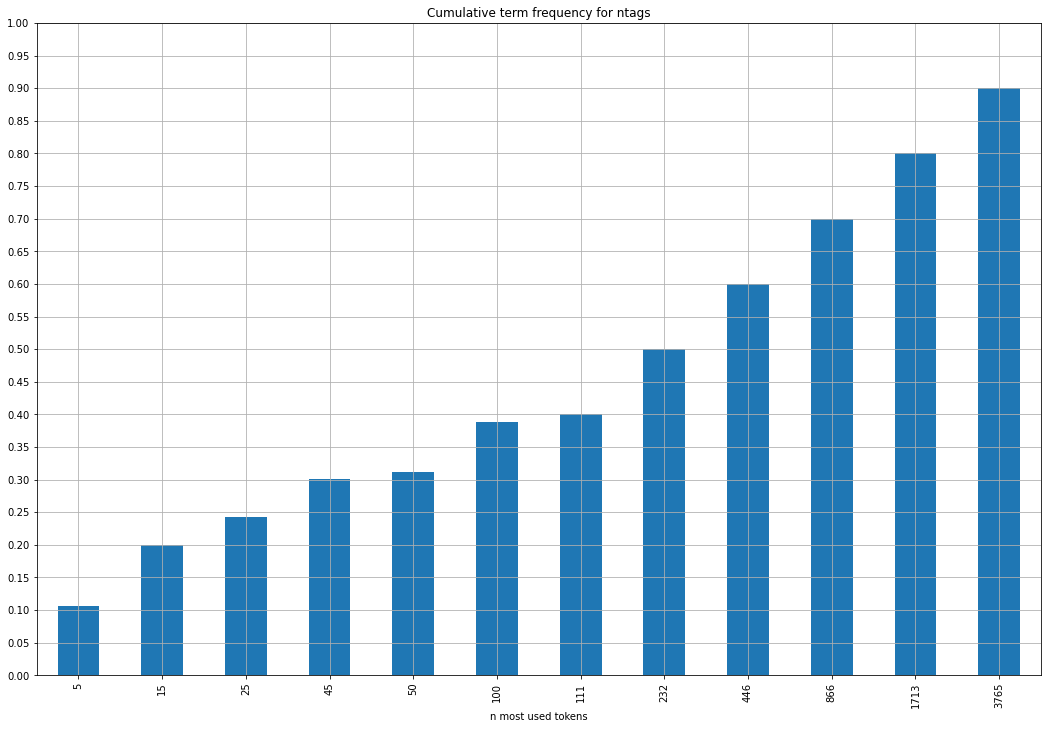

In [12]:
plot_token.termf_coverage(data,'ntags',ns=[25,50,100])

##### document frequency

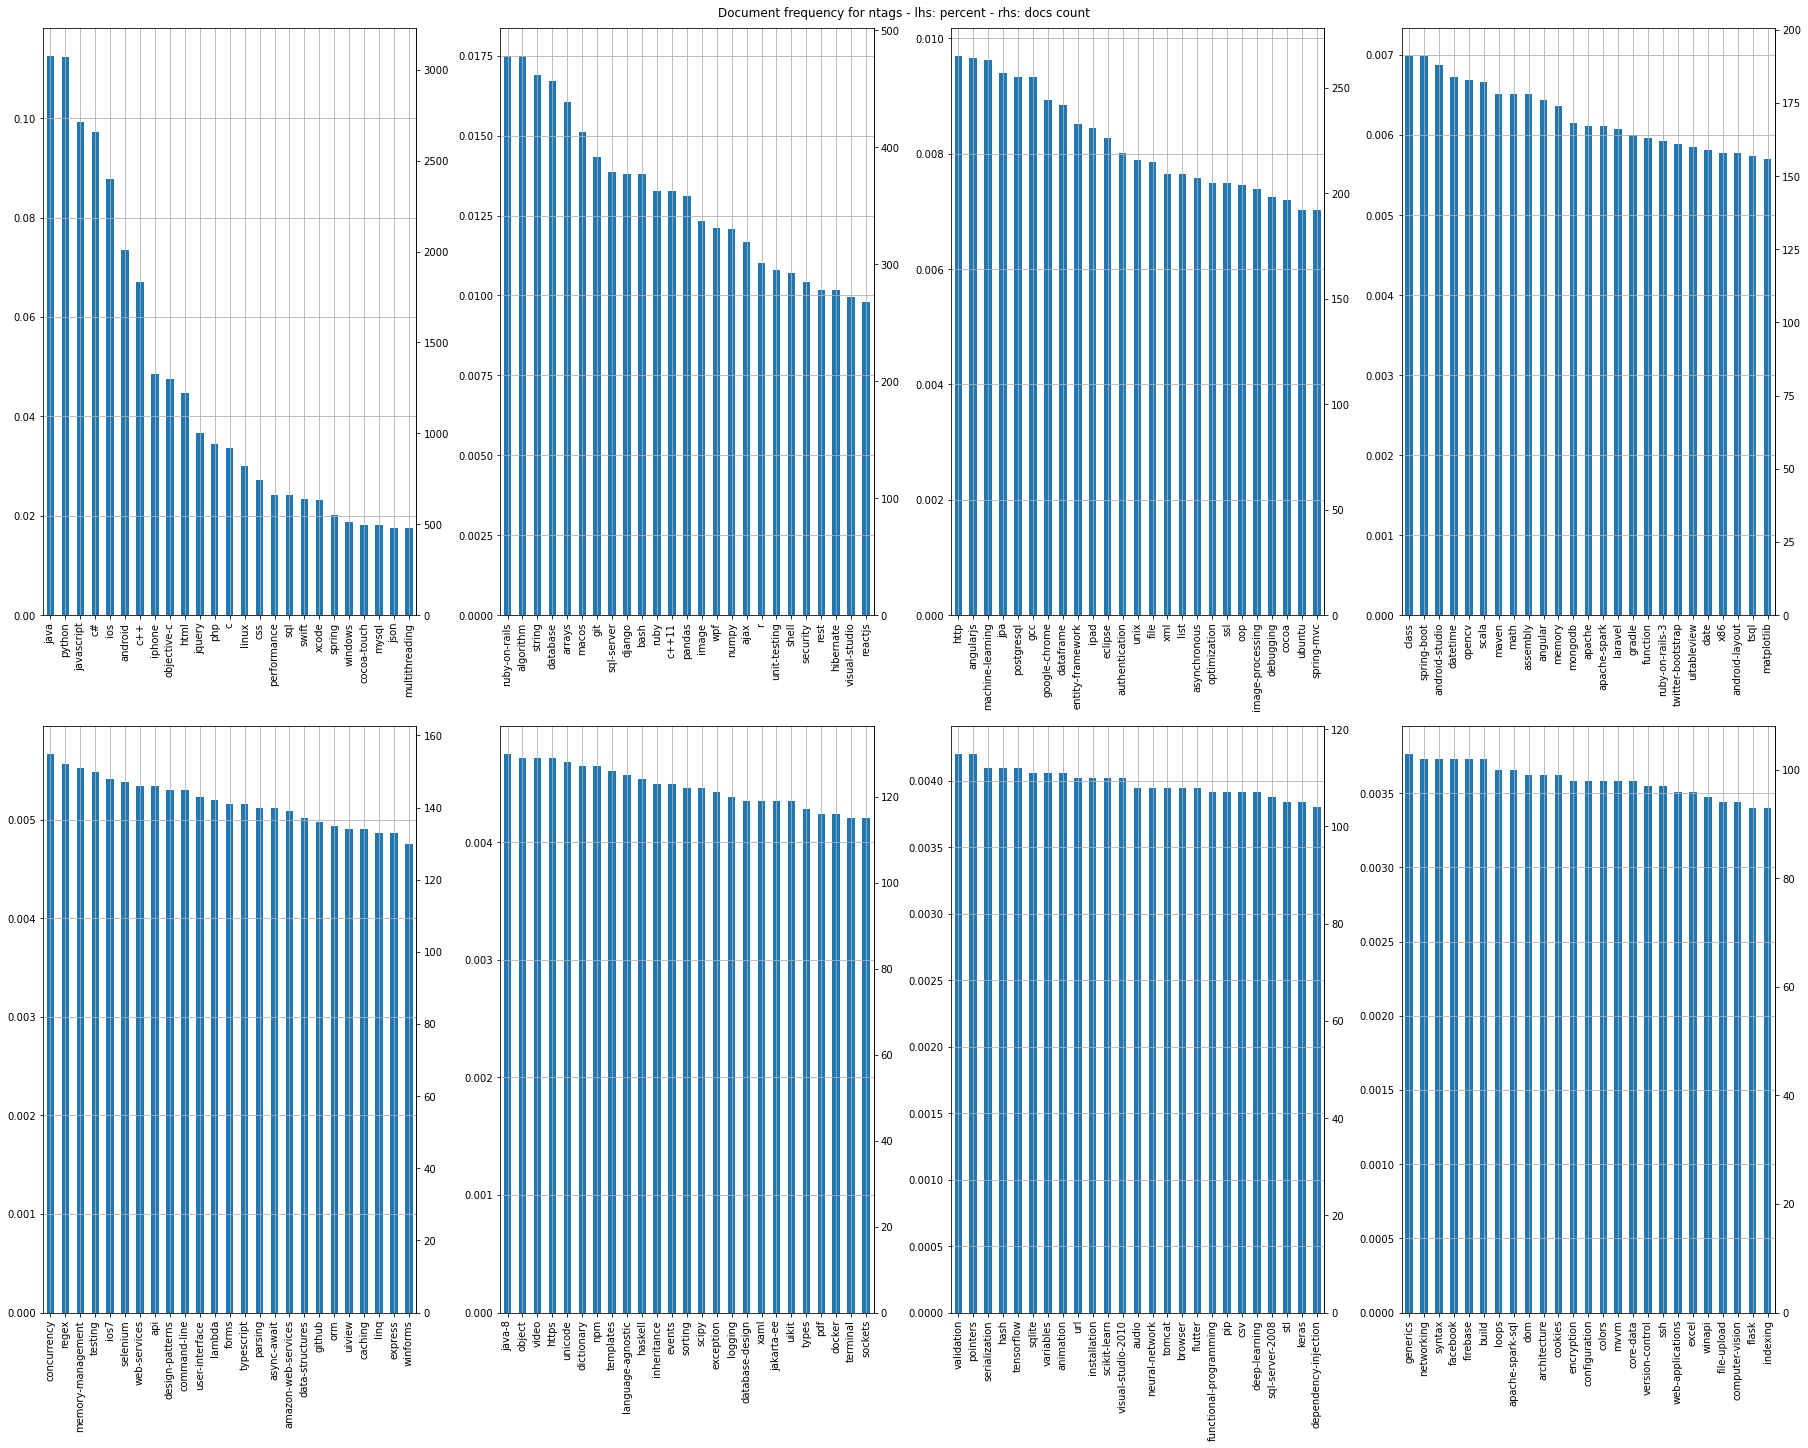

In [13]:
plot_token.plot_docf(data,'ntags',n=200,figsize_=(25,20))

##### word cloud

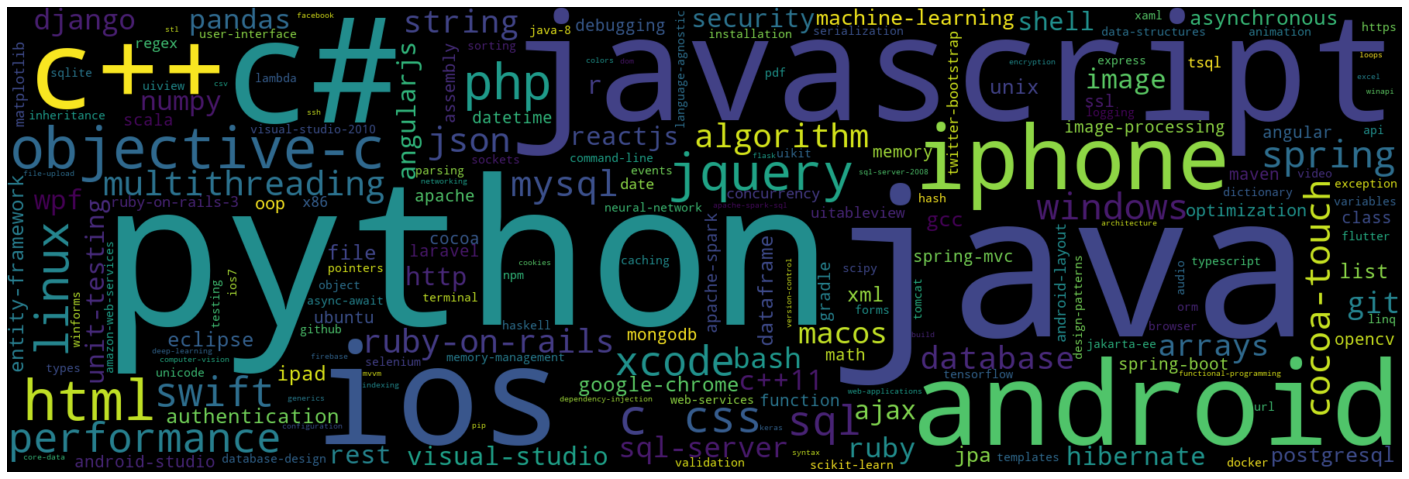

In [14]:
plot_token.display_word_cloud(data,"ntags",200)

#### Body stats

##### cumulative term frequency

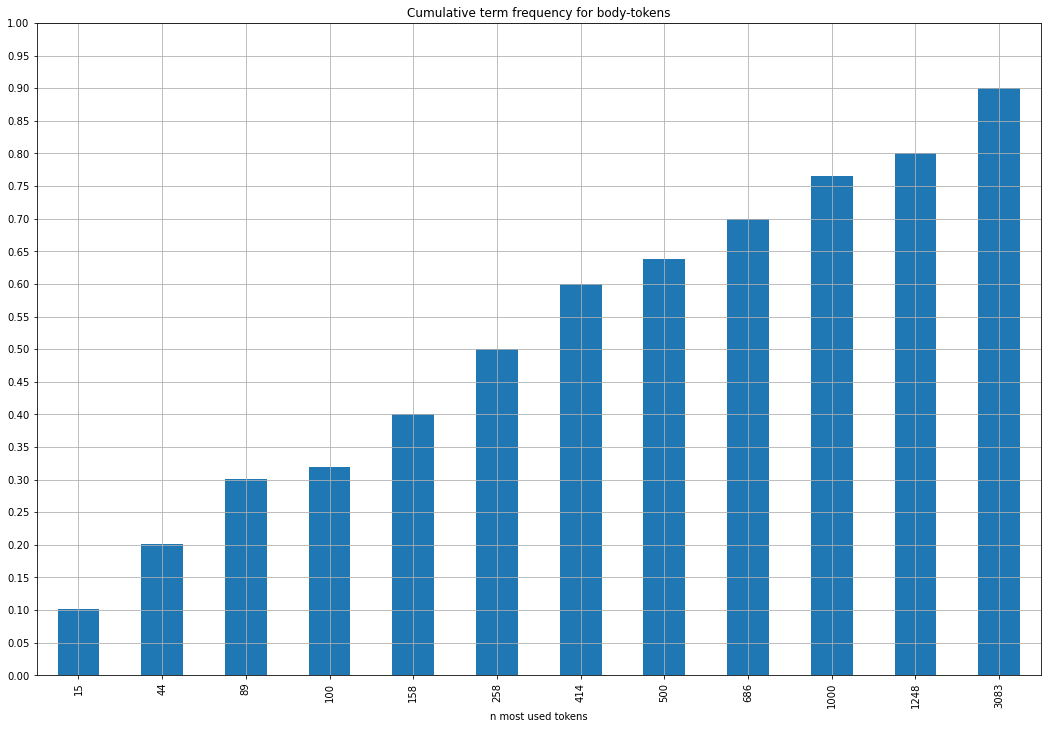

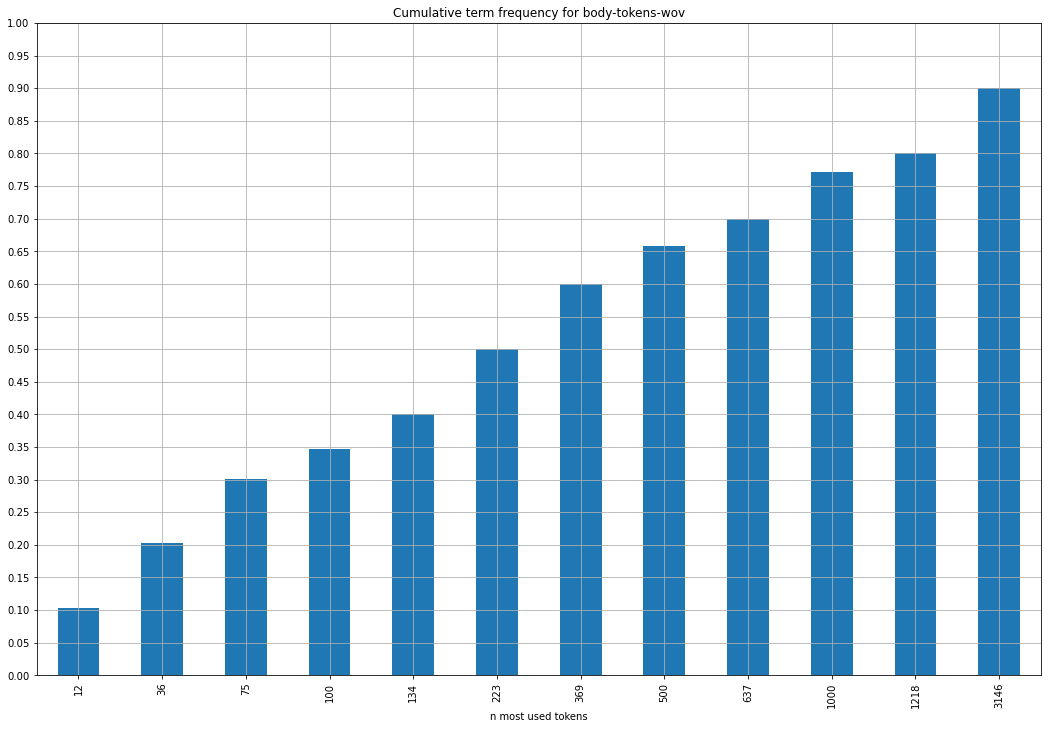

In [15]:
plot_token.termf_coverage(data,'body-tokens',ns=[100,500,1000])
plot_token.termf_coverage(data,'body-tokens-wov',ns=[100,500,1000])

##### document frequency

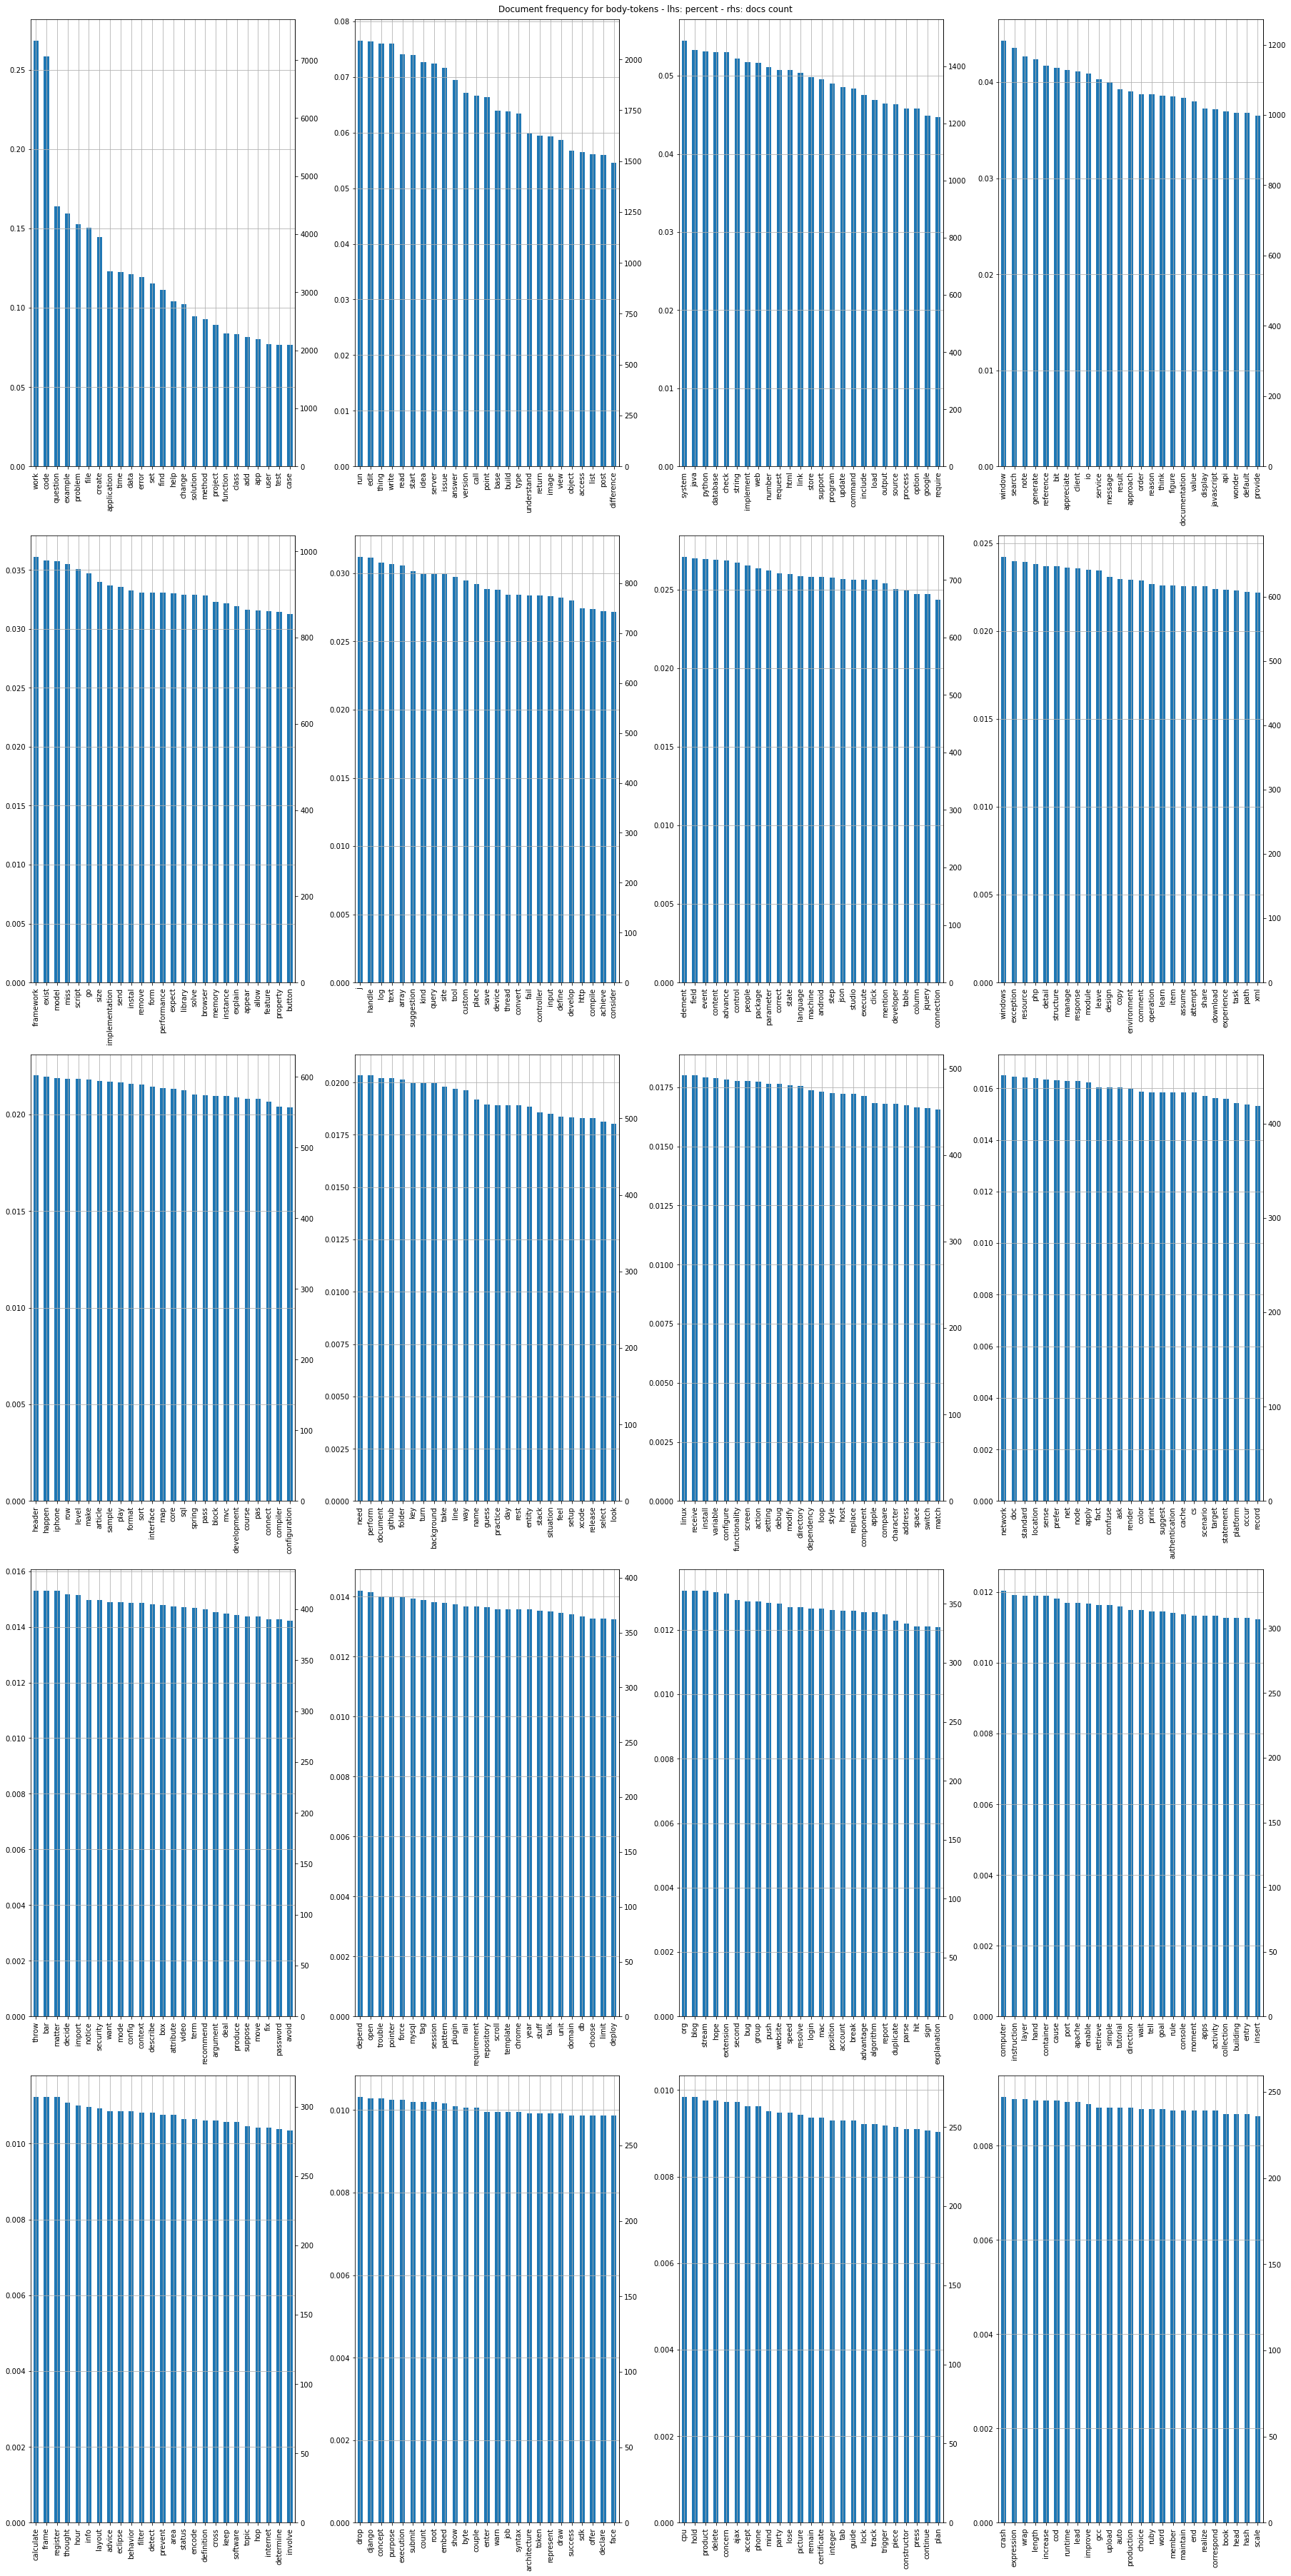

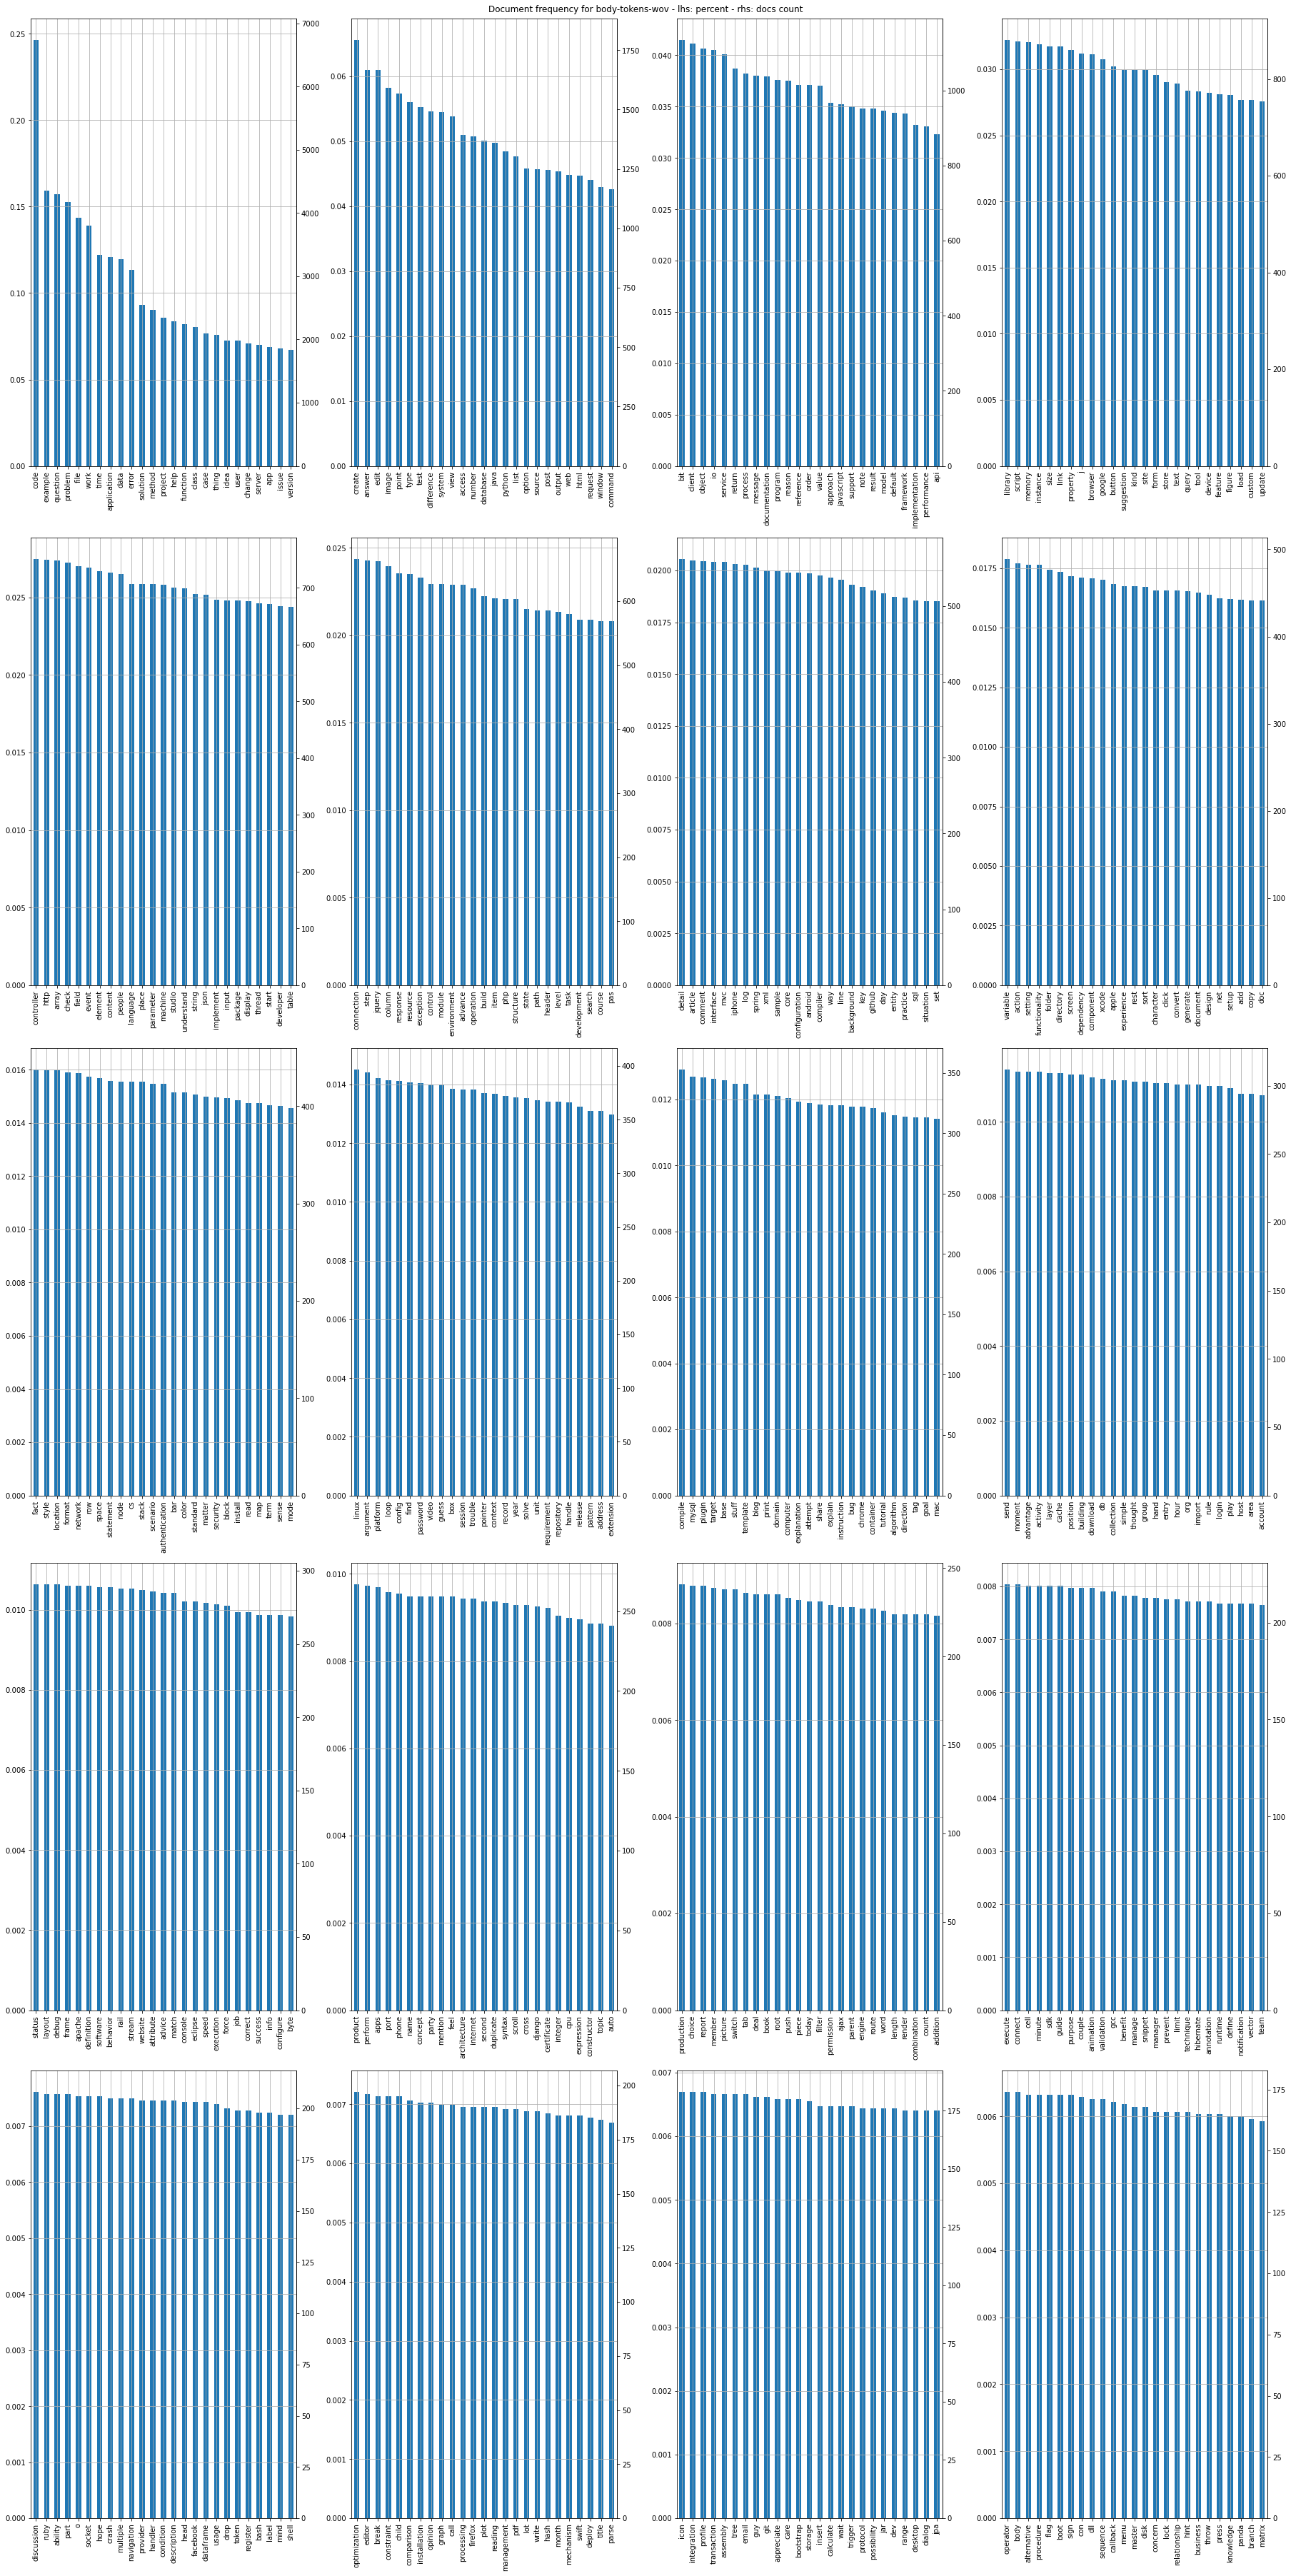

In [16]:
plot_token.plot_docf(data,'body-tokens',n=500)
plot_token.plot_docf(data,'body-tokens-wov',n=500)

##### Word cloud

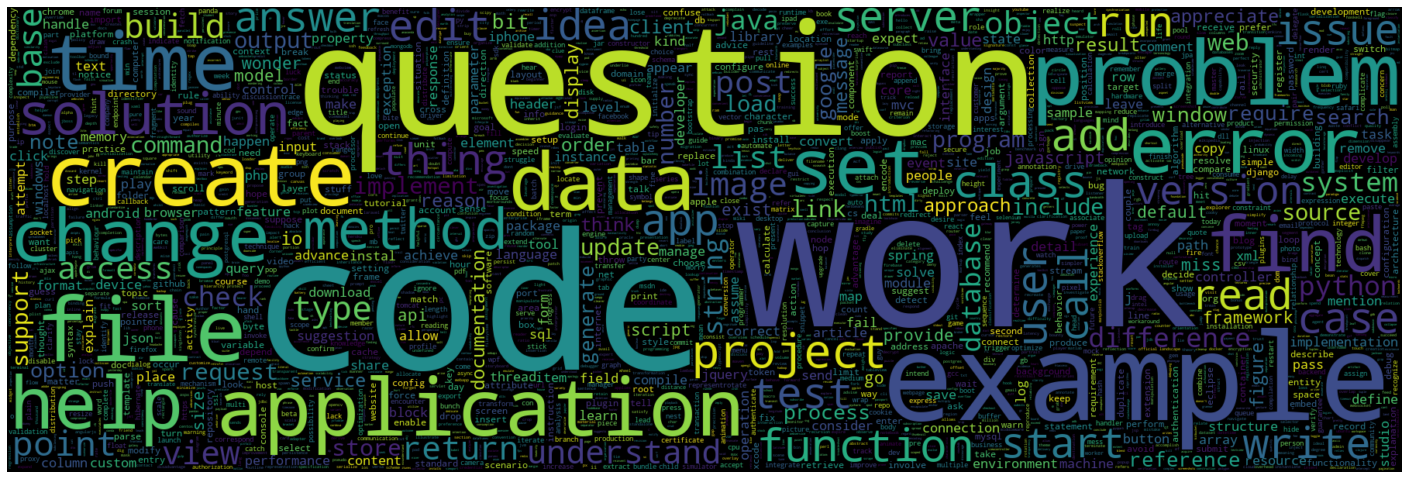

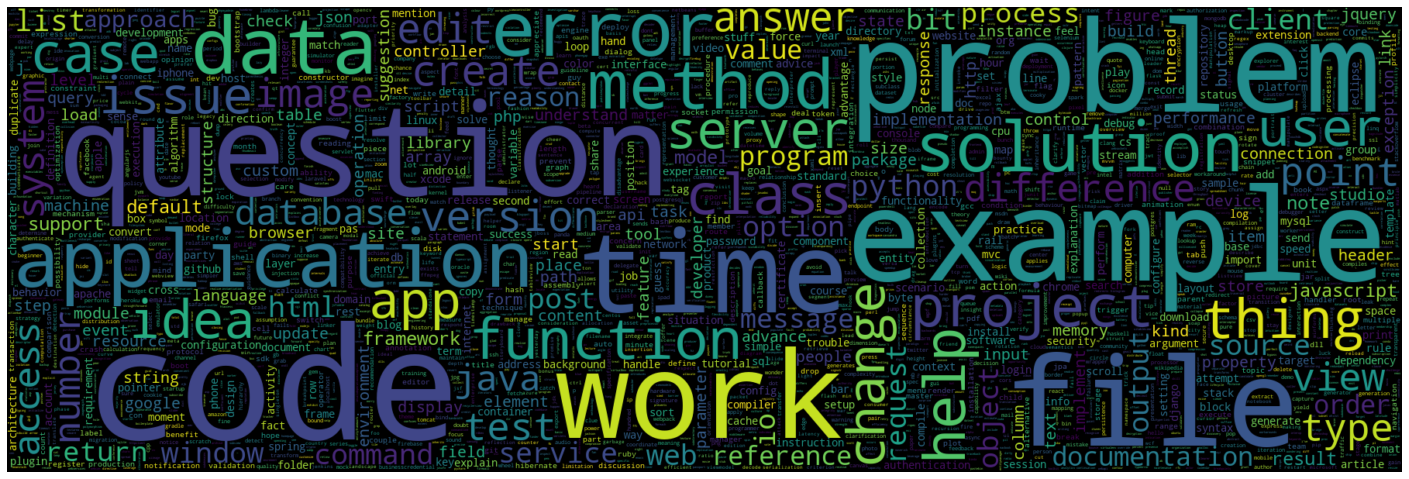

In [17]:
plot_token.display_word_cloud(data,'body-tokens')
plot_token.display_word_cloud(data,'body-tokens-wov')

#### Title stats

##### cumulative term frequency

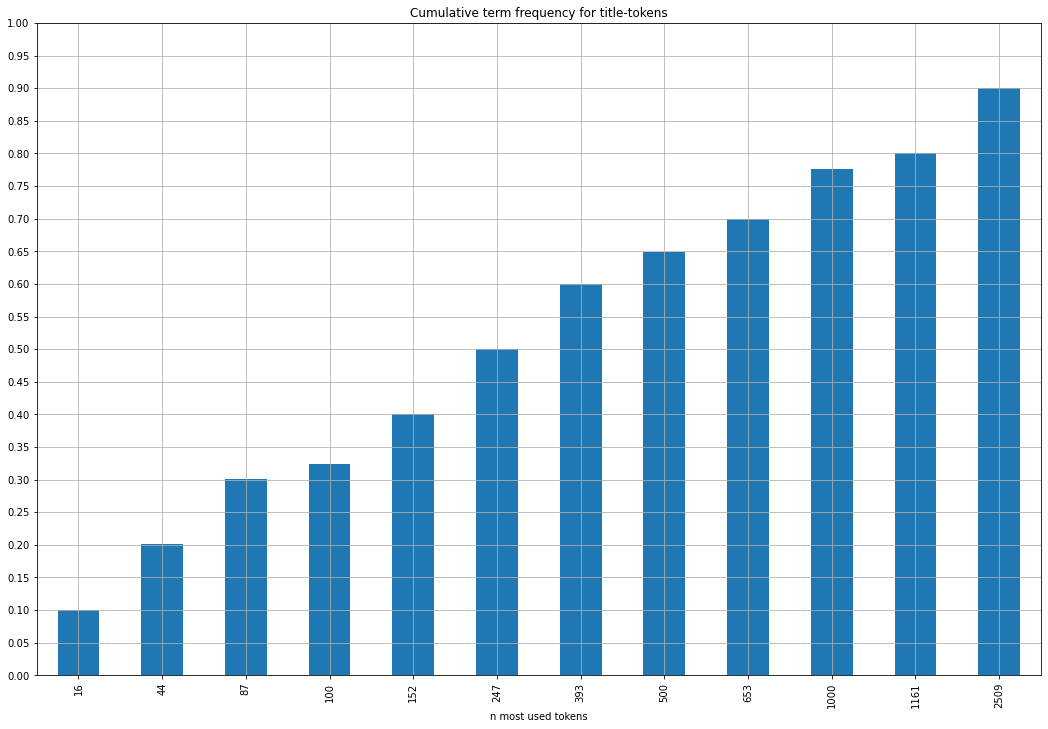

In [18]:
plot_token.termf_coverage(data,'title-tokens',ns=[100,500,1000])

##### document frequency

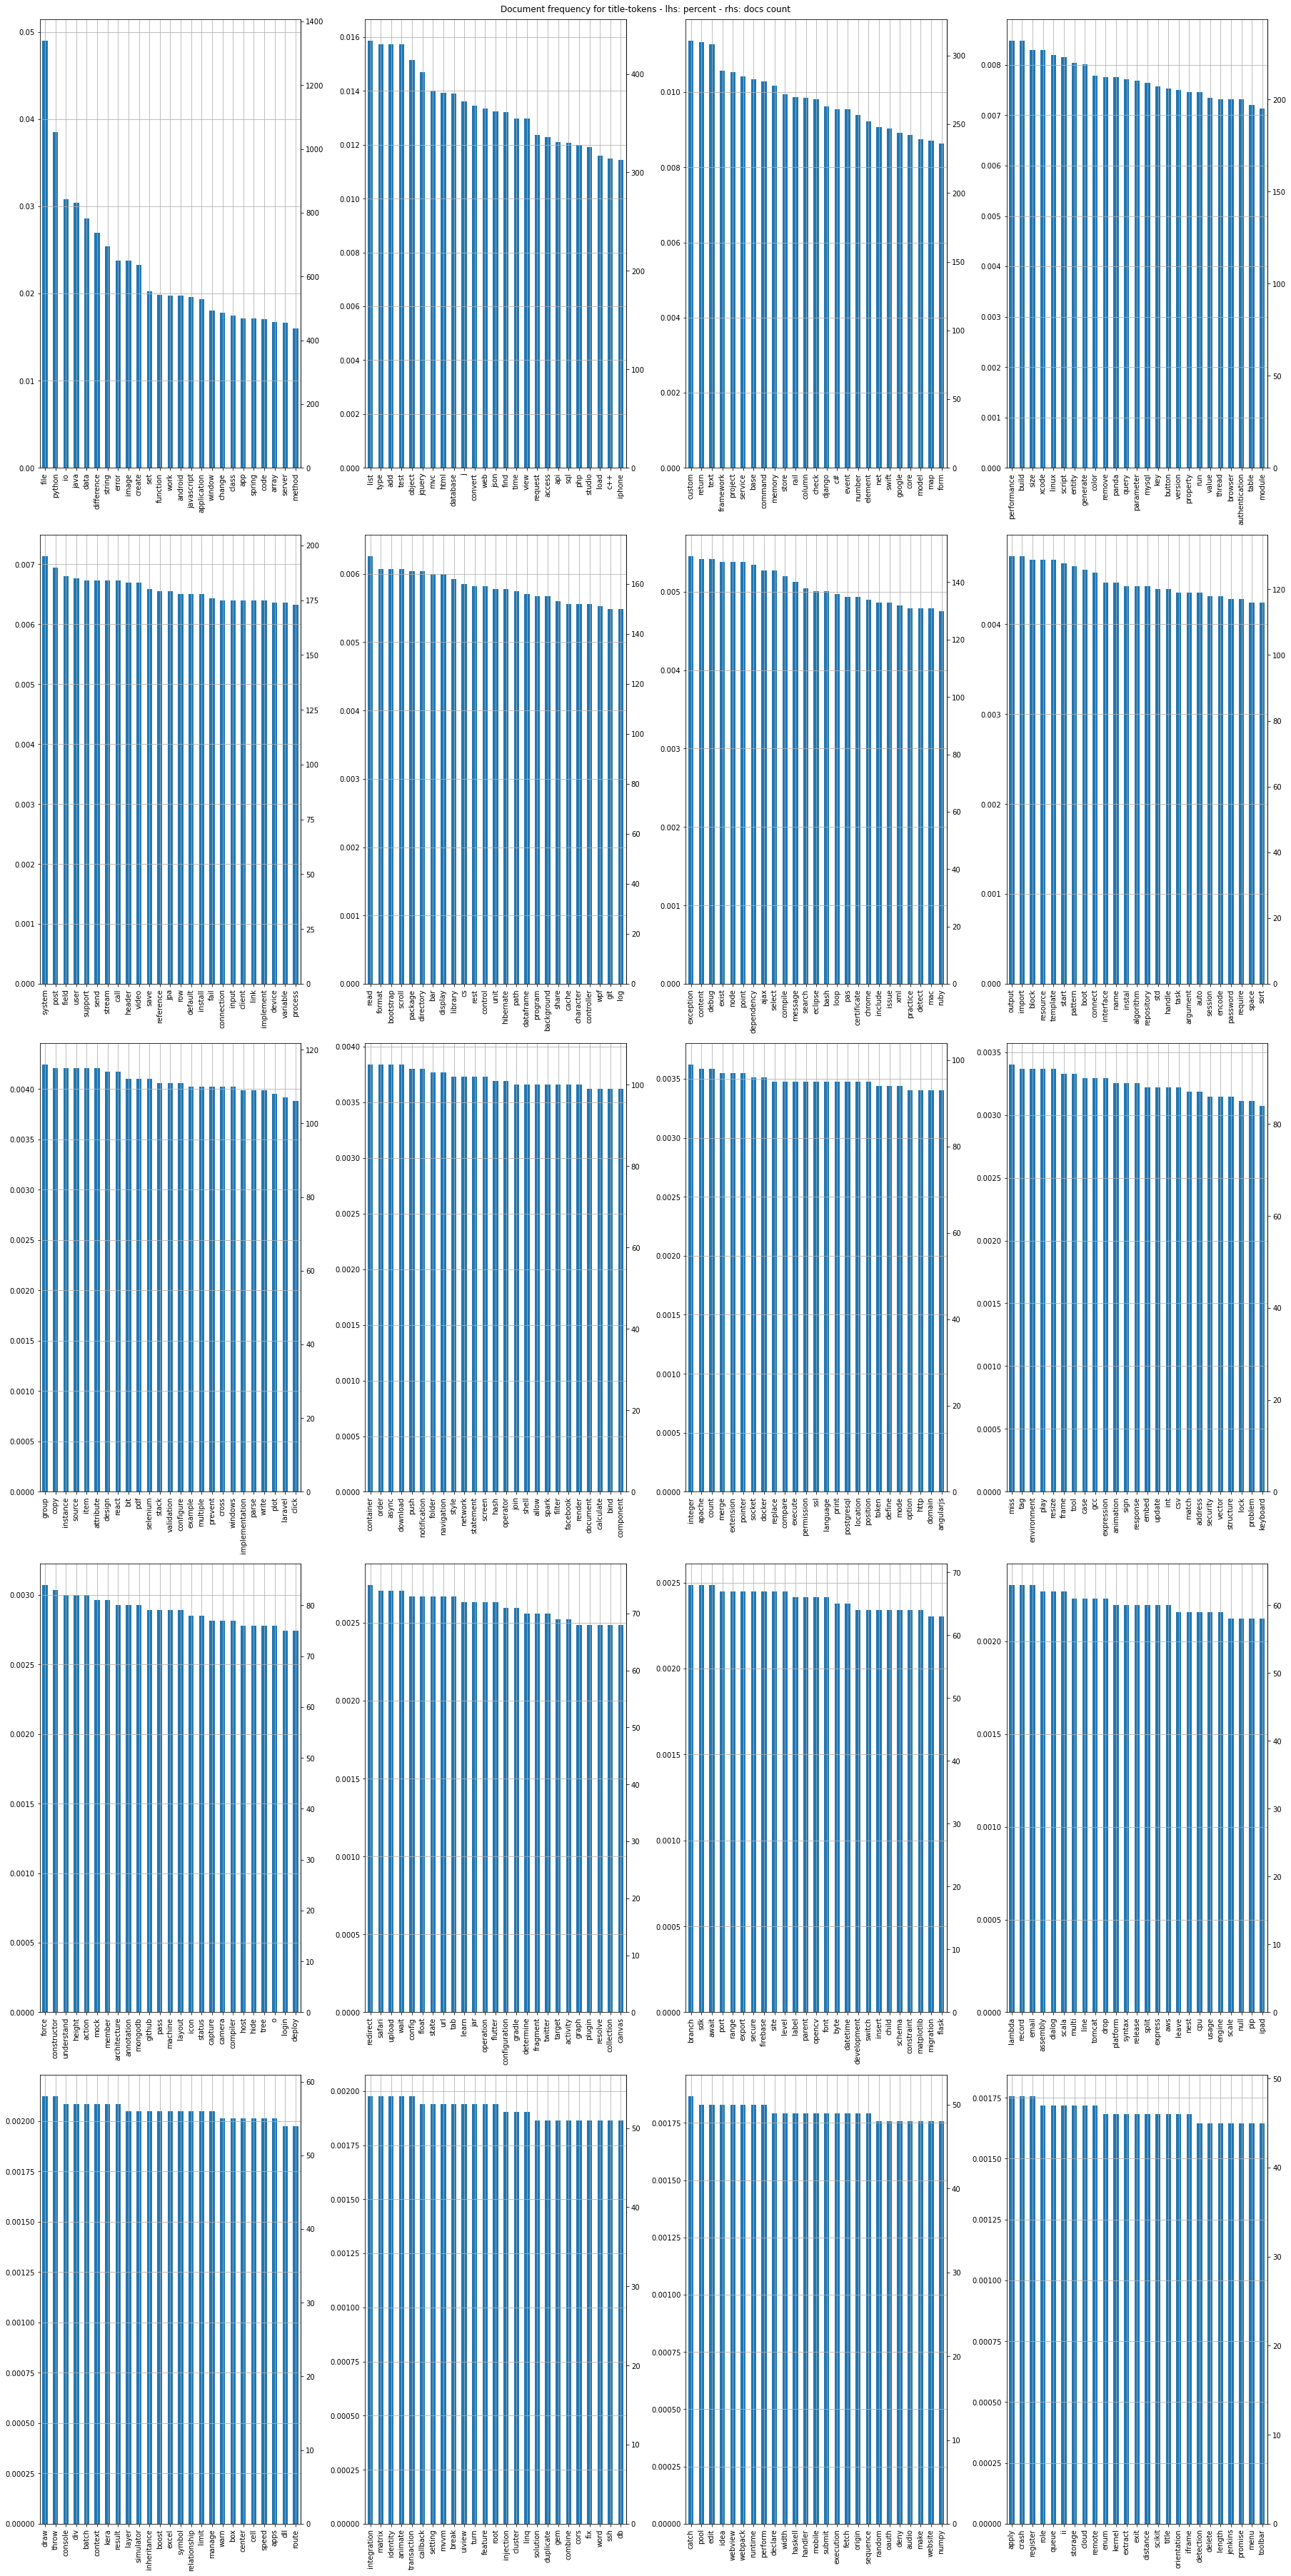

In [19]:
plot_token.plot_docf(data,'title-tokens',n=500)

##### word cloud

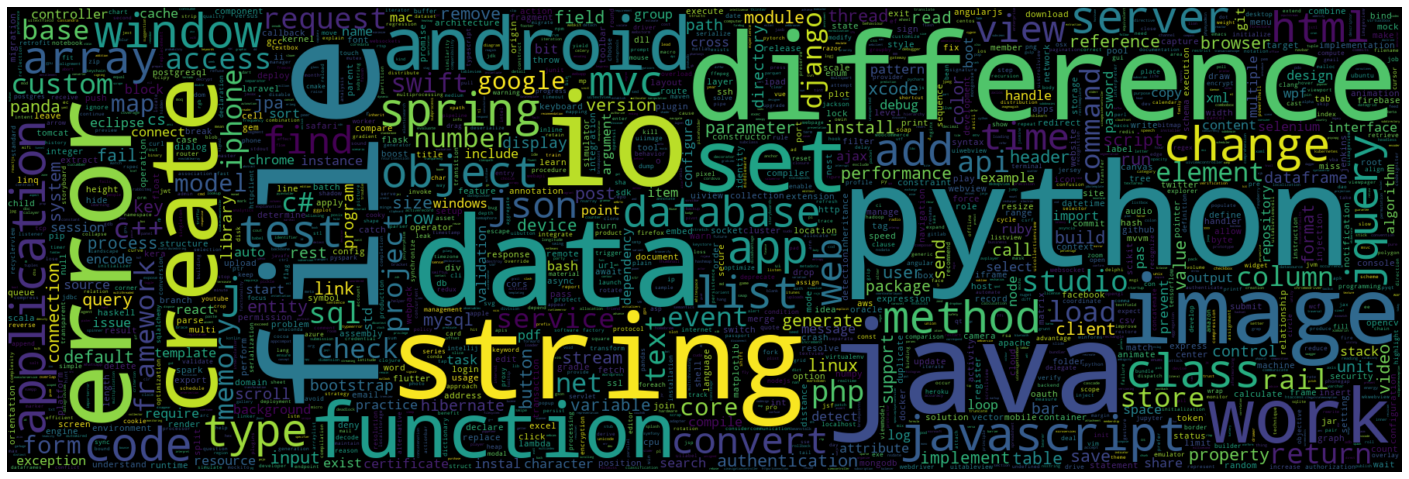

In [20]:
plot_token.display_word_cloud(data,'title-tokens')

### PCA analysis

body_min: 0.005998975784622138 - body_max: 0.05457604799180628 - title_min: 0.0021215889970005123 - title_max: 1.0
pca.shape: (27338, 713)


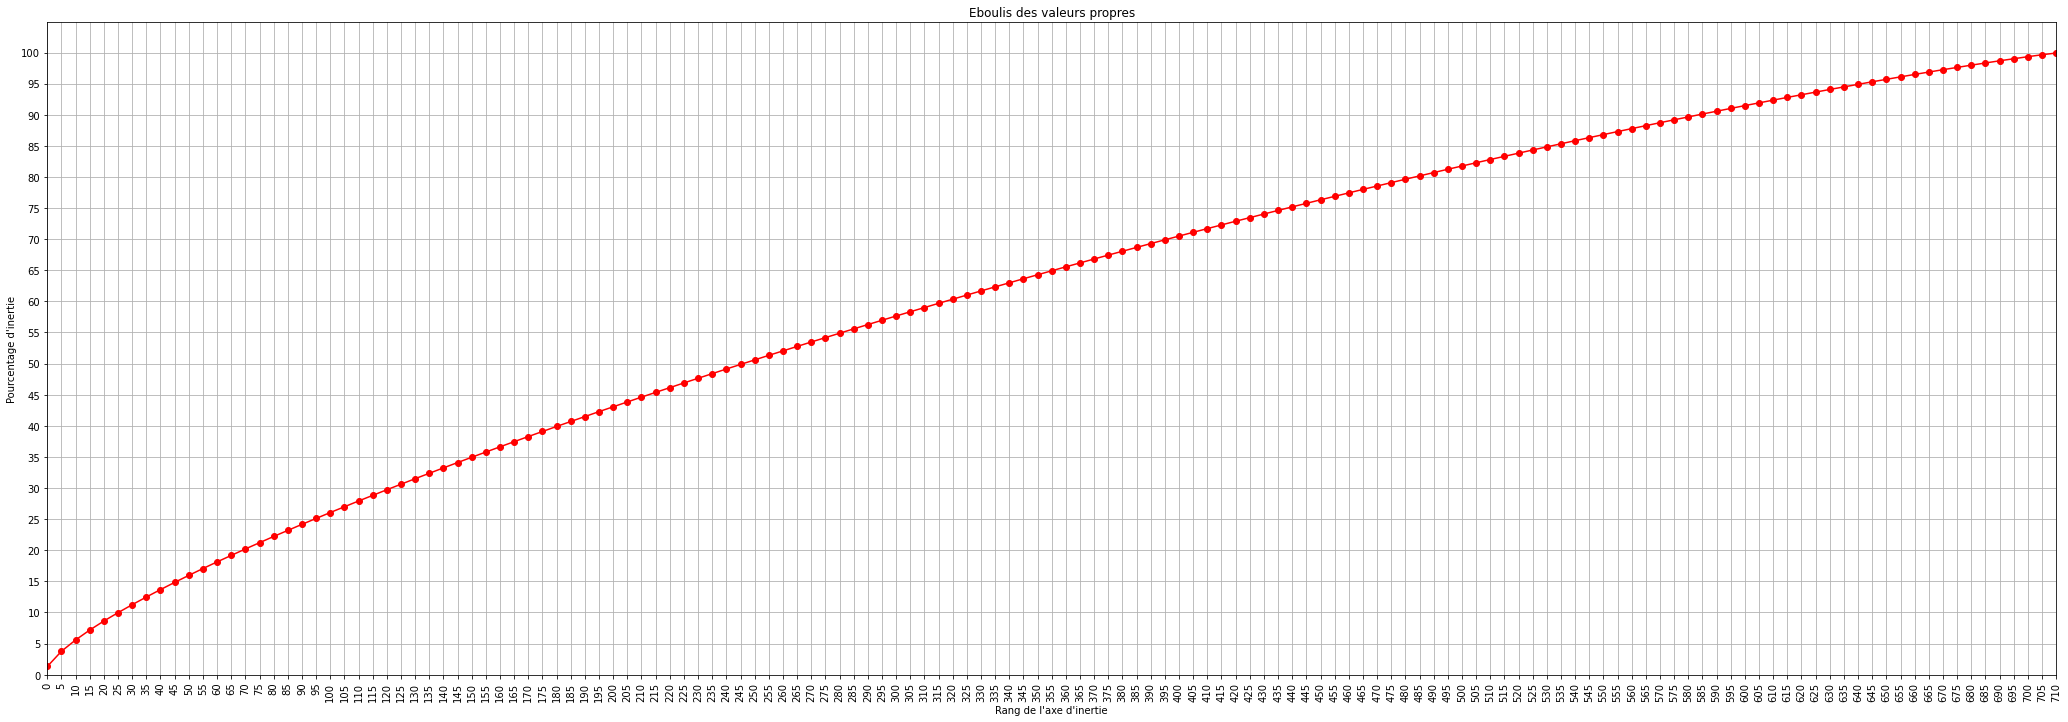

In [21]:
plot_token.display_pca(data,body_min=164*one_doc,body_max=1492*one_doc,title_min=58*one_doc,title_max=1.0)

body_min: 0.017631136147487014 - body_max: 0.05457604799180628 - title_min: 0.007535298851415613 - title_max: 1.0
pca.shape: (27338, 246)


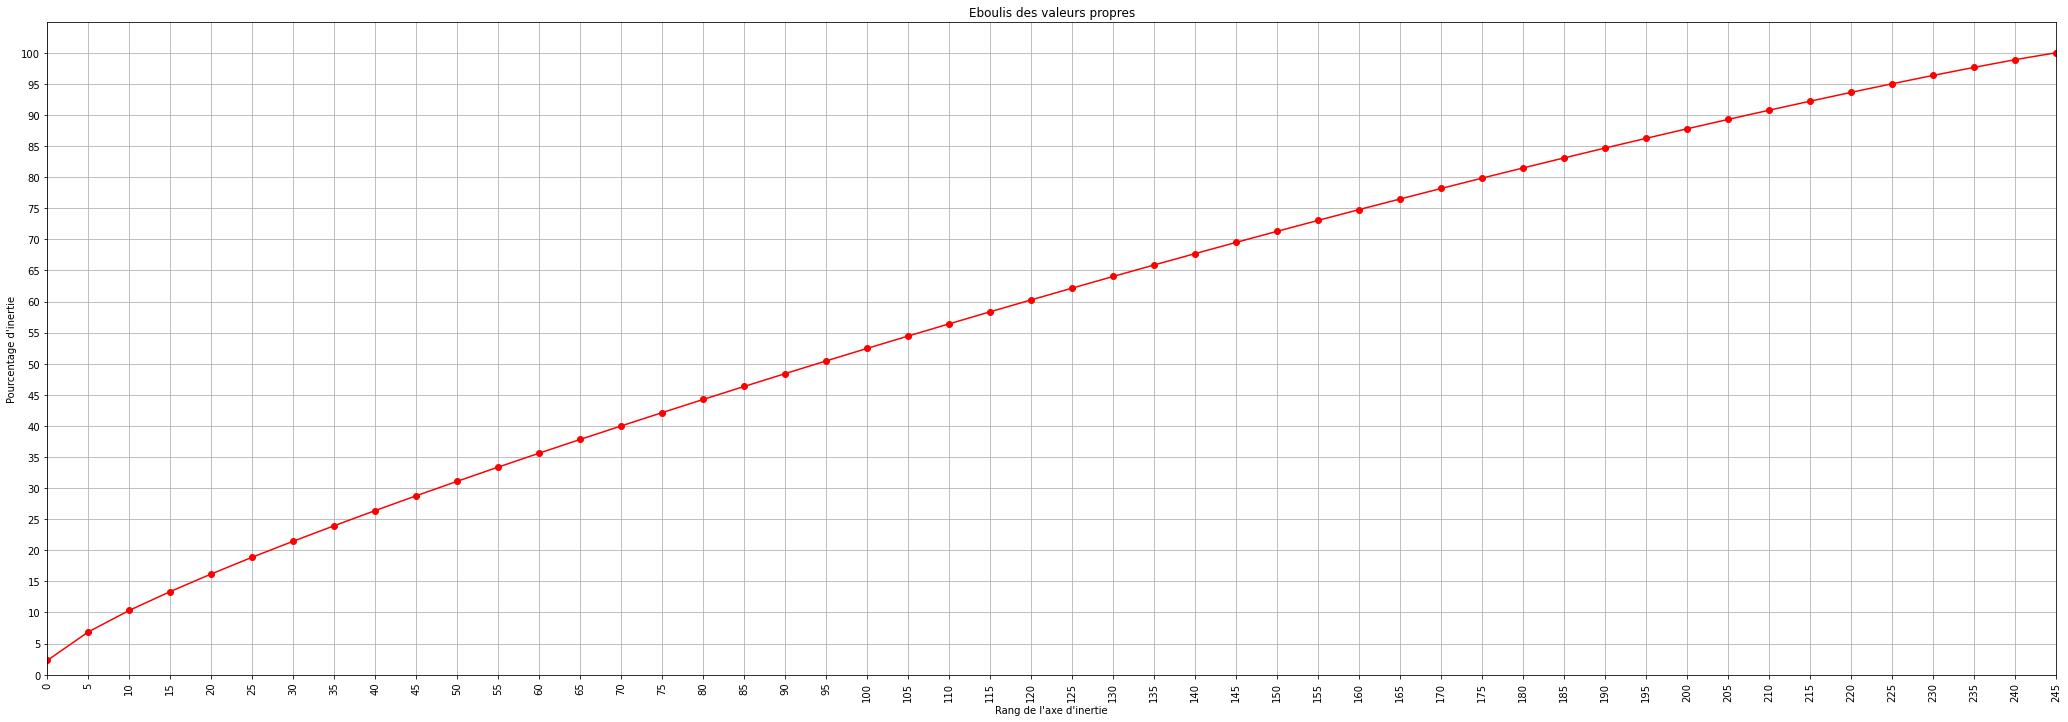

In [22]:
plot_token.display_pca(data,body_min=482*one_doc,body_max=1492*one_doc,title_min=206*one_doc,title_max=1.0)

body_min: 0.003840807666983686 - body_max: 1.0 - title_min: 0.0021215889970005123 - title_max: 1.0
pca.shape: (27338, 737)


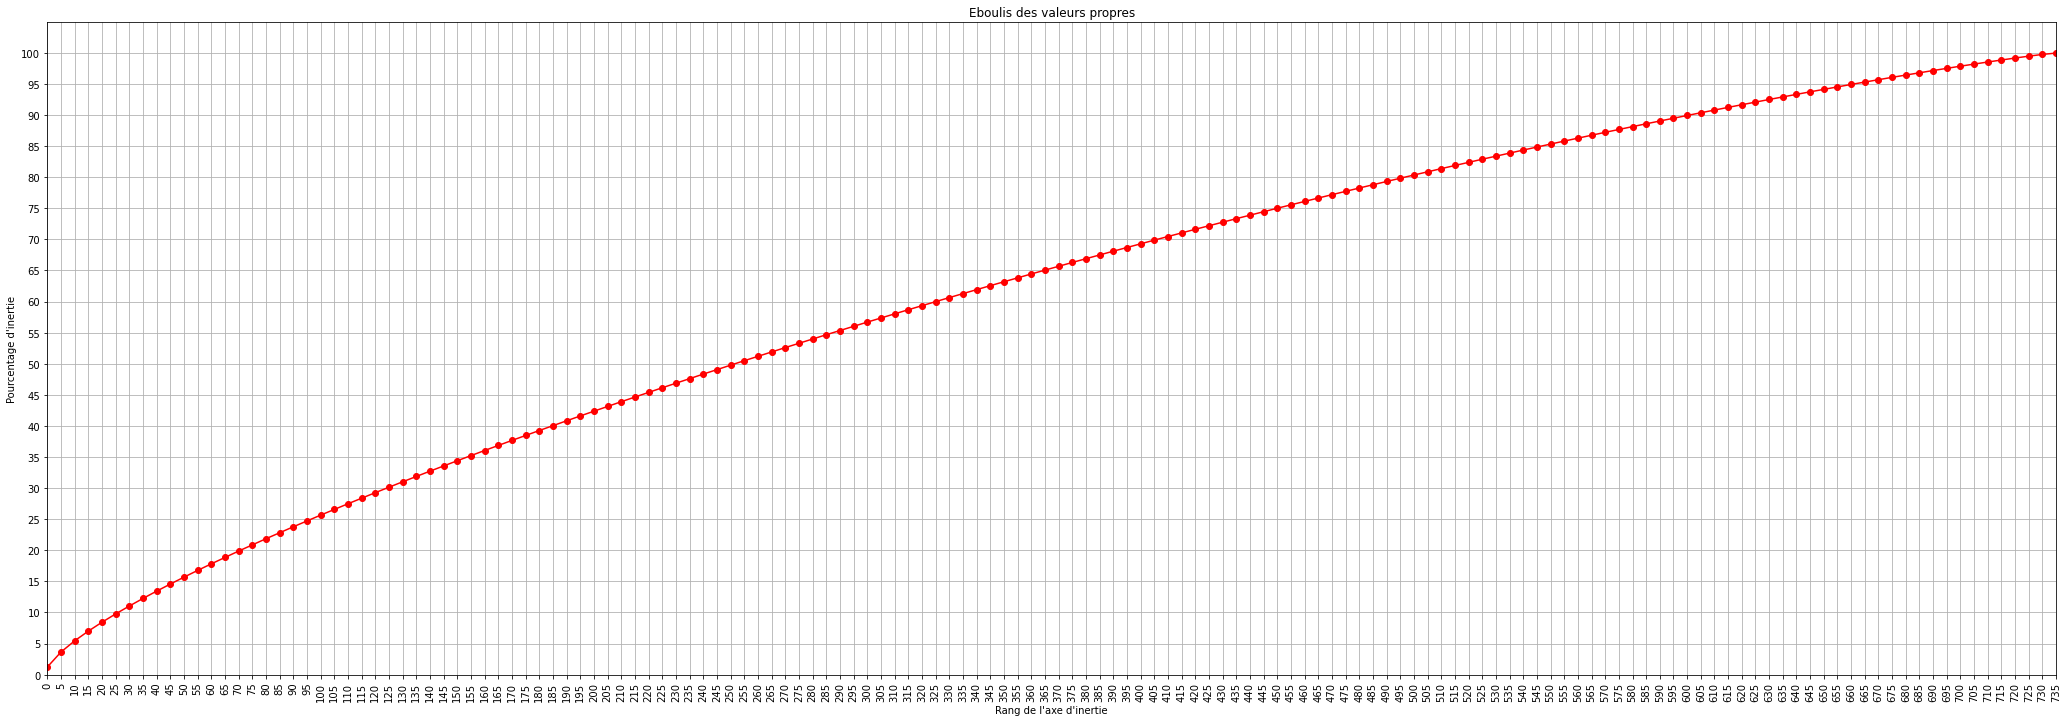

In [23]:
plot_token.display_pca(data,body_min=105*one_doc,body_max=1.0,title_min=58*one_doc,title_max=1.0,col_body='body-tokens-wov')

### Save results

In [24]:
data['title-tokens'] = data['title-tokens'].apply(preprocessing.make_filter_list(exclude=['code','data']))
data['body-tokens-wov'] = data['body-tokens-wov'].apply(preprocessing.make_filter_list(exclude=['code','question','problem','data','help','thing','idea','imagine']))
data.to_csv(f'{path}/{results}')